# Run reduced-rank network

In [2]:
import os
import numpy as np
import random
from sklearn.decomposition import PCA

from utils.UtilsIO import UtilsIO
from utils.UtilsPlotting import UtilsPlotting
from utils.UtilsSamplingLocs import UtilsSamplingLocs
from utils.UtilsOpDims import UtilsOpDims
from utils.input_generation.InputGeneratorCtxt import InputGeneratorCtxt
from utils.input_generation.InputGeneratorSWG import InputGeneratorSWG
from utils.run_one_forwardPass import run_one_forwardPass
from utils.remove_dimension_from_weight_matrix import remove_dimension_from_weight_matrix
from utils.get_mse import get_mse
from utils.get_state_distance_between_trajs import get_state_distance_between_trajs

UIO  = UtilsIO()
UPlt = UtilsPlotting()
USL = UtilsSamplingLocs()
UOD = UtilsOpDims()

base_dir_data = '../data'

In [3]:
# network settings
net_id = 1
network_type = 'ctxt'  # 'swg': sine wave generator network 'ctxt': context-dependent integration network
dim_type = 'columns'  # 'columns' 'rows'

# noise settings
with_netnoise    = 1  # 0 or 1
with_inputnoise  = 1  # 0 or 1, only for ctxt network

seed_run   = 1001
seed_input = 1000

# SHARED CONSTANTS / PARAMETERS
# load network weights
path_to_weights = os.path.join(base_dir_data, 'pretrained_networks', network_type, network_type+'_weights.h5')
[n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1] = UIO.load_weights(path_to_weights, net_id)
n_units = np.shape(n_Wrr_n)[0]

# network noise
if with_netnoise:
    net_noise   = 'default'
else:
    net_noise   = 0

# generate network inputs to run network
random.seed(seed_input)
if network_type == 'swg':
    n_trials = 51*3  # total, over all 51 frequencies
    coherencies_trial = []  # dummy
    [all_freqs, all_freq_ids, inputs, targets, conditionIds] = InputGeneratorSWG().get_sine_wave_generator_inputOutputDataset(n_trials)
    
elif network_type == 'ctxt':
    n_trials = 5  # trials per context and per input coherency
    all_freq_ids = []  # dummy
    [coherencies_trial, conditionIds, inputs, targets] = InputGeneratorCtxt().get_ctxt_dep_integrator_inputOutputDataset(n_trials, with_inputnoise)
    
else:
    raise Exception("Network type unknown, please set network_type to 'swg' or 'ctxt'")

## Generate global operative dimensions

In [4]:
# load  local operative dimensions
sampling_loc_props = USL.get_sampling_location_properties(network_type)

inputfilename = os.path.join(base_dir_data, 'local_operative_dimensions', 'localOpDims_'+network_type+'_'+dim_type+'.h5')
[all_local_op_dims, all_fvals] = UOD.load_local_op_dims(inputfilename, n_units, sampling_loc_props, network_type)

# combine local operative dimensions to obtain global operative dimensions 
sampling_locs_to_combine = 'all' # options for ctxt network: 'ctxt1' 'ctxt2' 'allPosChoice' 'allNegChoice'
[global_op_dims, singular_values_of_global_op_dims] = UOD.get_global_operative_dimensions(sampling_locs_to_combine, sampling_loc_props, all_local_op_dims, all_fvals)

## Run full-rank and reduced-rank network

### Compare network output

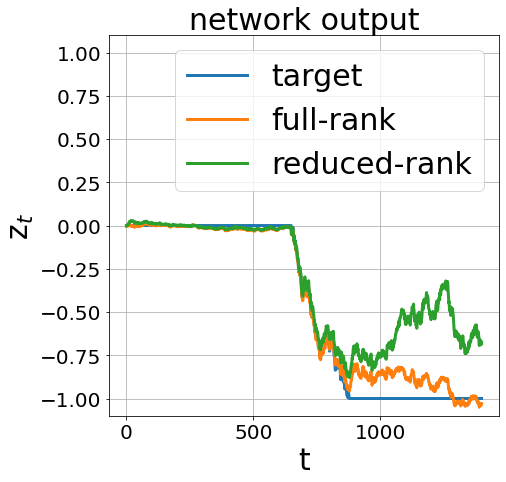

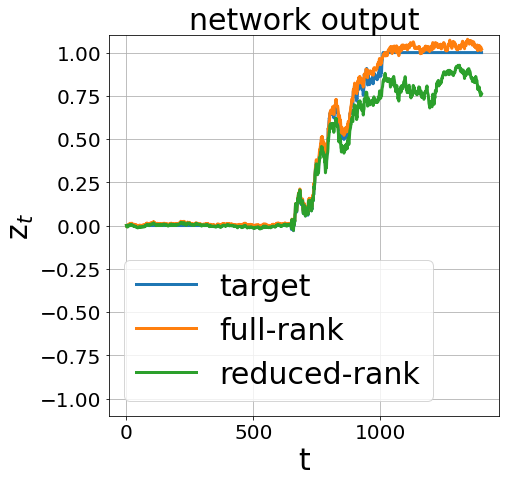

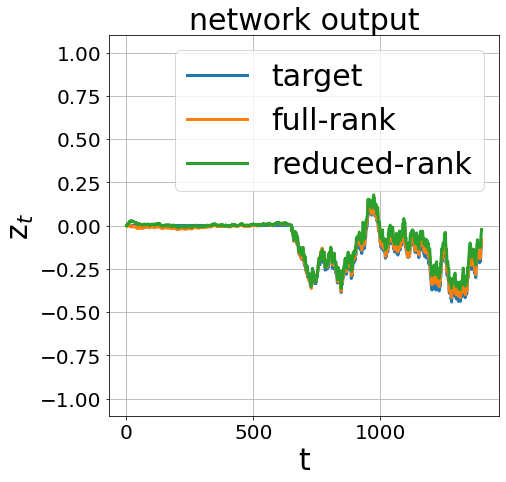

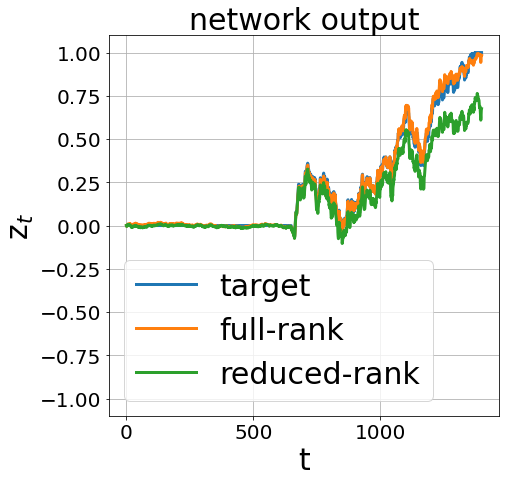

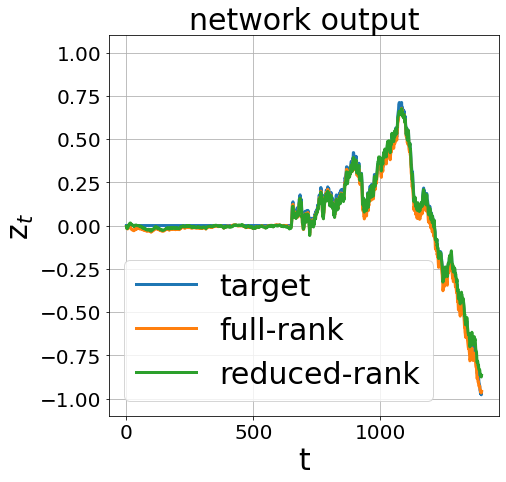

In [5]:
# & COMPARE NETWORK OUTPUT AND CONDITION AVERAGE TRAJECTORIES
if dim_type == 'columns':
    if network_type == 'ctxt':
        rankW = 15  # set rank of reduced-rank W
    elif network_type == 'swg':
        rankW = 29
elif dim_type == 'rows':
    if network_type == 'ctxt':
        rankW = 27  # set rank of reduced-rank W
    elif network_type == 'swg':
        rankW = 41
        
# run full-rank network
forwardPass_fullRank = run_one_forwardPass(n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1, inputs, conditionIds, seed_run, net_noise)
# run reduced-rank network
n_Wrr_n_modified = remove_dimension_from_weight_matrix(n_Wrr_n, global_op_dims[:, rankW:n_units+1], dim_type)
forwardPass_reducedRank = run_one_forwardPass(n_Wru_v, n_Wrr_n_modified, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1, inputs, conditionIds, seed_run, net_noise)        
      
# plot network outputs for several trials
for trial_nr in np.arange(1,25,5):
    y_data = np.concatenate([np.reshape(targets[0,:,trial_nr], [-1, 1]), 
                             np.reshape(forwardPass_fullRank["m_z_t"][0, :, trial_nr], [-1, 1]), 
                             np.reshape(forwardPass_reducedRank["m_z_t"][0, :, trial_nr], [-1, 1])], axis=1)
    [fig, ax] = UPlt.plot_lineplot(range(np.shape(targets)[1]), y_data, "network output", "t", "z$_t$", display_names=["target", "full-rank", "reduced-rank"])
    ax.set_ylim(bottom=-1.1, top=1.1)

### Compare condition average trajectories

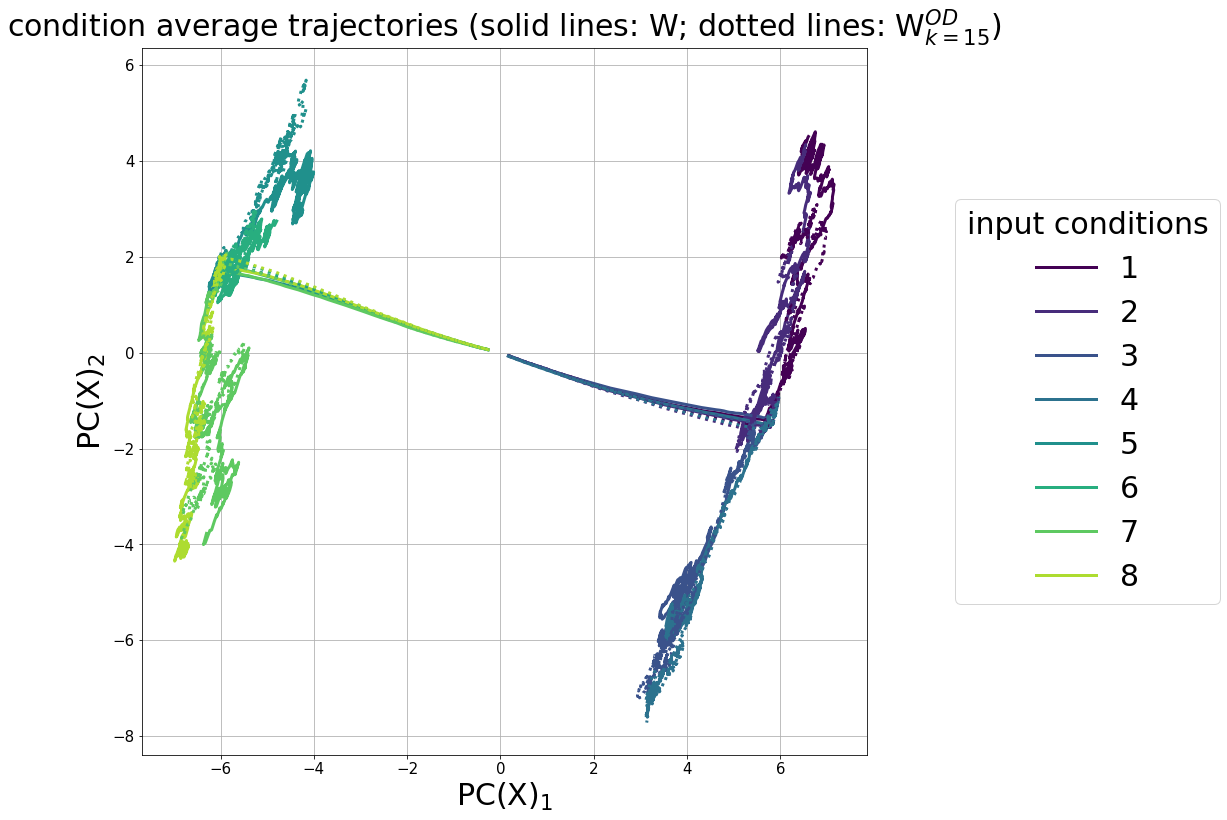

In [6]:
# plot one example trials for network trajectory
[fig, ax] = UPlt.plot_full_and_reduced_rank_condAvgTrajs(forwardPass_fullRank["n_x_t"], forwardPass_reducedRank["n_x_t"], 
                sampling_loc_props, all_freq_ids, conditionIds, coherencies_trial, network_type, rankW)